In [1]:
%cd /content
!rm -rf /content/OptIForest
!git clone --depth 1 https://github.com/xiagll/OptIForest.git /content/OptIForest
%cd /content/OptIForest


/content
Cloning into '/content/OptIForest'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 0), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 191.65 KiB | 215.00 KiB/s, done.
/content/OptIForest


In [2]:
# np.mat to np.asmatrix (NumPy 2.0 compatibility)
!sed -i 's/np.mat(/np.asmatrix(/g' /content/OptIForest/detectors/opt_tree.py

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score


IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    BASE_DIR = "/content/optiforest_data"
else:
    BASE_DIR = "./optiforest_data"

os.makedirs(BASE_DIR, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [4]:
if IN_COLAB:
    from google.colab import files
    print("Please upload creditcard.csv")
    uploaded = files.upload()   # choose creditcard.csv
    csv_path = list(uploaded.keys())[0]
else:
    csv_path = "data/creditcard.csv"  # relative path in your repo

df = pd.read_csv(csv_path)
print(df.shape, df.columns[:10], "... loaded.")
df.head()


Please upload creditcard.csv


Saving creditcard.csv to creditcard.csv
(284807, 31) Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9'], dtype='object') ... loaded.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Prepare labels and features
assert "Class" in df.columns
y = df["Class"].astype(int).values
X = df.drop(columns=["Class"])

print("Class counts:", pd.Series(y).value_counts().to_dict())
print("Anomaly ratio:", float(y.mean()))


Class counts: {0: 284315, 1: 492}
Anomaly ratio: 0.001727485630620034


In [6]:
# Train/test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)   # Fit scaler on train set
X_test_s  = scaler.transform(X_test)    # Apply same scaling to test set


In [7]:
# Save scaled splits to CSV
train_df = pd.DataFrame(X_train_s, columns=X.columns)
train_df["label_binary"] = y_train
test_df  = pd.DataFrame(X_test_s, columns=X.columns)
test_df["label_binary"] = y_test

train_csv = os.path.join(BASE_DIR, "ccfraud_train.csv")
test_csv  = os.path.join(BASE_DIR, "ccfraud_test.csv")
train_df.to_csv(train_csv, index=False)  # Store train split for reuse
test_df.to_csv(test_csv, index=False)   # Store test split for reuse

print("Saved:")
print("-", train_csv)
print("-", test_csv)

Saved:
- /content/optiforest_data/ccfraud_train.csv
- /content/optiforest_data/ccfraud_test.csv


In [8]:
# Baseline: IsolationForest
iso = IsolationForest(
    n_estimators=400,
    contamination="auto",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
iso.fit(X_train_s)
scores_test = -iso.decision_function(X_test_s)

auc = roc_auc_score(y_test, scores_test)
ap  = average_precision_score(y_test, scores_test)
print(f"[CreditCard] IsolationForest → AUC-ROC: {auc:.4f} | AUC-PR: {ap:.4f}")


[CreditCard] IsolationForest → AUC-ROC: 0.9501 | AUC-PR: 0.1875


In [9]:
# OptIForest on credit-card data
from detectors.opt_iforest import OptIForest

THRESHOLD = 403
BRANCH    = 0

optif_cc = OptIForest(
    lsh_family="L2OPT",
    num_trees=100,
    threshold=THRESHOLD,
    branch=BRANCH,
    granularity=1,
)

print("Fitting OptIForest on credit-card dataset...")
optif_cc.fit(X_train_s)

if hasattr(optif_cc, "decision_function"):
    of_scores_cc = -np.asarray(optif_cc.decision_function(X_test_s), dtype=float)
elif hasattr(optif_cc, "score_samples"):
    of_scores_cc = -np.asarray(optif_cc.score_samples(X_test_s), dtype=float)
else:
    preds_cc = optif_cc.predict(X_test_s)
    of_scores_cc = (np.asarray(preds_cc) == -1).astype(float)  # 1 for anomaly, 0 for normal

cc_auc_of = roc_auc_score(y_test, of_scores_cc)
cc_ap_of  = average_precision_score(y_test, of_scores_cc)

print(f"[CreditCard] OptIForest → AUC-ROC: {cc_auc_of:.4f} | AUC-PR: {cc_ap_of:.4f}")


Fitting OptIForest on credit-card dataset...


/content/OptIForest/detectors/opt_tree.py:56: RuntimeWarning: invalid value encountered in scalar divide
  children[key] = self._recursive_build(child_data, depth_limit, min(0.0, (children_count[key] -mean) /std), cur_index +1)


[CreditCard] OptIForest → AUC-ROC: 0.9491 | AUC-PR: 0.1391


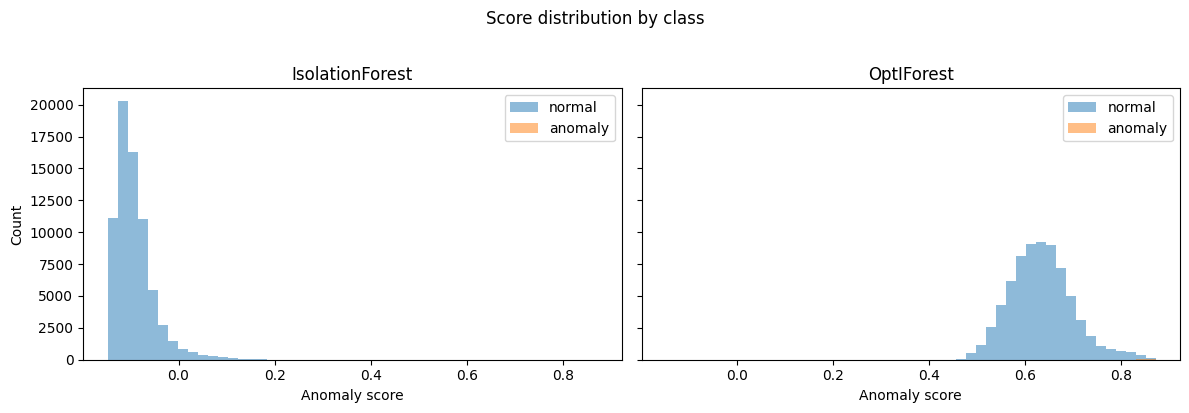

In [11]:
scores_iso = scores_test          # from IsolationForest
scores_of  = of_scores_cc         # from OptIForest

mask_normal = (y_test == 0)
mask_anom   = (y_test == 1)

vmin = float(min(scores_iso.min(), scores_of.min()))
vmax = float(max(scores_iso.max(), scores_of.max()))
bins = np.linspace(vmin, vmax, 50)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(scores_iso[mask_normal], bins=bins, alpha=0.5, label="normal")
axes[0].hist(scores_iso[mask_anom],   bins=bins, alpha=0.5, label="anomaly")
axes[0].set_title("IsolationForest")
axes[0].set_xlabel("Anomaly score")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(scores_of[mask_normal], bins=bins, alpha=0.5, label="normal")
axes[1].hist(scores_of[mask_anom],   bins=bins, alpha=0.5, label="anomaly")
axes[1].set_title("OptIForest")
axes[1].set_xlabel("Anomaly score")
axes[1].legend()

fig.suptitle("Score distribution by class", y=1.02)
plt.tight_layout()
plt.show()

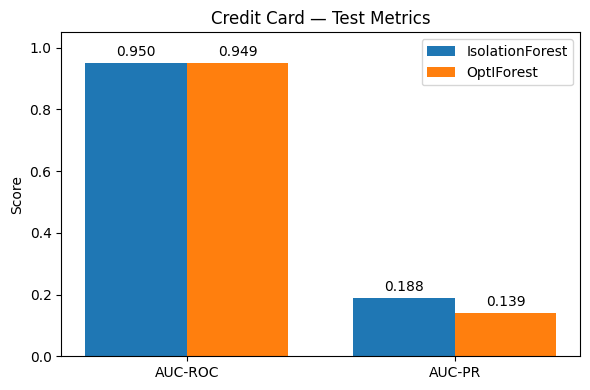

In [12]:
iso_auc = roc_auc_score(y_test, scores_test)
iso_ap  = average_precision_score(y_test, scores_test)
of_auc  = roc_auc_score(y_test, of_scores_cc)
of_ap   = average_precision_score(y_test, of_scores_cc)

metrics = ["AUC-ROC", "AUC-PR"]
iso_vals = [iso_auc, iso_ap]
of_vals  = [of_auc,  of_ap]

x = np.arange(len(metrics)); w = 0.38
fig, ax = plt.subplots(figsize=(6,4))
b1 = ax.bar(x - w/2, iso_vals, w, label="IsolationForest")
b2 = ax.bar(x + w/2, of_vals,  w, label="OptIForest")
ax.set_ylim(0, 1.05); ax.set_xticks(x, metrics)
ax.set_ylabel("Score"); ax.set_title("Credit Card — Test Metrics"); ax.legend()
for bars in (b1, b2):
    for r in bars:
        h = r.get_height()
        ax.annotate(f"{h:.3f}", (r.get_x()+r.get_width()/2, h),
                    xytext=(0,3), textcoords="offset points", ha="center", va="bottom")
plt.tight_layout(); plt.show()
